# Project in Mahine Learning

Loading packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin

import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
def discretizeAttribution(df, features, excluders):
    df_copy = df.copy()
    for feature in features:
        index = 0
        dic = {}
        for items in df.get(feature):
            items = items.split(",")
            for item in items:
                if item not in dic and item not in excluders:
                    dic[item] = index
                    index += 1
        newFeature = []
        for items in df.get(feature):
            items = items.split(",")
            newFeature.append(np.zeros(len(dic)))
            for item in items:
                if item not in excluders:
                    newFeature[-1][dic[item]] = 1
        
        df_copy[feature] = newFeature
    return df_copy

In [3]:
def strToFloatArray(df, *features):
    df_copy = df.copy()
    for feature in features:
        newFeature  = []
        for item, index in zip(df[feature], range(len(df[feature]))):
            newFeature.append(np.array(item[1:-1].split(",")).astype(float))
        df_copy[feature] = newFeature
    return df_copy
        

def conserveNPC(df_train, df_test, feature, N):
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()
    temp = preprocessing.scale(np.vstack(df_train_copy[feature]))
    pca = PCA(n_components = N)
    pca.fit(temp)
    df_train_copy[feature] = pca.transform(temp).tolist()
    temp = preprocessing.scale(np.vstack(df_test_copy[feature]))
    df_test_copy[feature] = pca.transform(temp).tolist()
    return df_train_copy, df_test_copy

def splitArrayIntoColumns(df, *features):
    df_copy = df.copy()
    for feature in features:
        newFeature = np.vstack(np.array(df_copy[feature]))
        for index in range(len(newFeature[0])):
            df_copy[feature + str(index)] = newFeature[:, index]
        df_copy.drop(feature, axis = 1, inplace = True)
    return df_copy

In [4]:
def standardize(df, *excludedFeatures):
    df_copy = df.copy()
    for feature in df.keys():
        excluded = False
        for excludedFeature in excludedFeatures:
            if excludedFeature in feature:
                excluded = True
        if not excluded:
            df_copy[feature] = (df_copy[feature] - df_copy[feature].mean()) / df_copy[feature].std()
    return df_copy

def getCorrelatedFeatures(df, threshold = 0.8):
    corr = df.corr()
    feature_to_delete = []
    corr_max = 0
    for feature in df.keys():
        for feature2 in df.keys():
            if feature == feature2 :
                break

            if abs(corr[feature][feature2]) > threshold :
                feature_to_delete.append((feature, feature2))
            if abs(corr[feature][feature2]) > corr_max:
                corr_max = abs(corr[feature][feature2])

    print(feature_to_delete)
    print(corr_max)
    
def removeFeatureWithMI(df_train, df_test, target, N, worst=True):
    MI = mutual_info_regression(df_train, np.concatenate(target.to_numpy()))
    sorted_arg = np.flip(np.array(np.argsort(MI)))
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()
    if worst:
        df_train_copy = df_train_copy[df_train_copy.keys()[sorted_arg[:-N]]]
        df_test_copy = df_test_copy[df_test_copy.keys()[sorted_arg[:-N]]]
    else:
        df_train_copy = df_train_copy[df_train_copy.keys()[sorted_arg[:N]]]
        df_test_copy = df_test_copy[df_test_copy.keys()[sorted_arg[:N]]]
        
    return df_train_copy, df_test_copy

In [5]:
def removeOutliers(df, target, *excludedFeatures):
    df_copy = df.copy()
    target_copy = target.copy()
    threshold = 1.5
    for feature in df_copy.keys():
        excluded = False
        for excludedFeature in excludedFeatures :
            if excludedFeature in feature:
                excluded = True
        if not excluded :
            mean = np.mean(df_copy[feature])
            qi, qf = np.quantile(df_copy[feature], [0.25, 0.75])
            IQR = abs(qf - qi)
            target_copy.loc[df_copy[feature] > qf + threshold * IQR] = None
            target_copy.loc[df_copy[feature] < qi - threshold * IQR] = None
            df_copy.loc[df_copy[feature] > qf + threshold * IQR, feature] = None
            df_copy.loc[df_copy[feature] < qi - threshold * IQR, feature] = None

    df_copy = df_copy.dropna()
    target_copy = target_copy.dropna()
    
    return df_copy, target_copy

In [6]:
def open_data(path):
    X1path = pjoin(path, "X1.csv")
    X2path = pjoin(path, "X2.csv")
    Y1path = pjoin(path, "Y1.csv")

    X1 = pd.read_csv(X1path, na_values="\\N")
    X2 = pd.read_csv(X2path, na_values="\\N")
    Y1 = pd.read_csv(Y1path, na_values="\\N", header=None)
    
    return X1, X2, Y1

Loading data and first visualization

In [7]:
try :
    X1, X2, Y1 = open_data("C:\\Users\\Louis Lovat\\Desktop\\UNIF\\MachineLearning\\Project\\data")
except :
    X1, X2, Y1 = open_data("C:\\Users\\hchri\\Jupyter\\Machine learning\\project_data")


# Replacing NA values
    
for feature in X2.keys():
    print(feature, "\t", X2[feature].isna().sum())
    
print("Y1 ", Y1.isna().sum())

X1["runtime"].fillna(X1["runtime"].mean(), inplace=True)
print("runtime mean = ", X1["runtime"].mean())
X1["genres"].fillna("Unknown", inplace=True)

X2["runtime"].fillna(X2["runtime"].mean(), inplace=True)
print("runtime mean = ", X2["runtime"].mean())
X2["genres"].fillna("Unknown", inplace=True)

for feature in X2.keys():
    print(feature, "\t", X2[feature].isna().sum())
    

# Get rid of useless/unusable features
    
X1.drop(["img_url", "description", "title", "is_adult"], axis=1, inplace=True)
X2.drop(["img_url", "description", "title", 'is_adult'], axis=1, inplace=True)


# Re-working studio, genres and embeddings to make them usable

X1 = discretizeAttribution(X1, ["genres", "studio"], ["Unknown"])
X1 = strToFloatArray(X1, "img_embeddings", "text_embeddings")

X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2)

X_train, X_test = conserveNPC(X_train, X_test,  "img_embeddings", 100)
X_train, X_test = conserveNPC(X_train, X_test, "text_embeddings", 9)
X_train = splitArrayIntoColumns(X_train, "img_embeddings", "text_embeddings", "studio", "genres")
X_test = splitArrayIntoColumns(X_test, "img_embeddings", "text_embeddings", "studio", "genres")
X_train, Y_train = removeOutliers(X_train, Y_train, 'studio', 'genre', 'text_embeddings', 'img_embeddings')
X_train = standardize(X_train, 'is_adult', 'studio', 'genre')
X_test = standardize(X_test, 'is_adult', 'studio', 'genre')
getCorrelatedFeatures(X_train, threshold = 0.8)
X_train, X_test = removeFeatureWithMI(X_train, X_test, Y_train, 50)

Unnamed: 0 	 0
title 	 0
img_url 	 0
description 	 0
ratings 	 0
n_votes 	 0
is_adult 	 0
production_year 	 0
runtime 	 106
genres 	 4
release_year 	 0
studio 	 0
img_embeddings 	 0
text_embeddings 	 0
Y1  0    0
dtype: int64
runtime mean =  92.29334554334548
runtime mean =  92.01983002832843
Unnamed: 0 	 0
title 	 0
img_url 	 0
description 	 0
ratings 	 0
n_votes 	 0
is_adult 	 0
production_year 	 0
runtime 	 0
genres 	 0
release_year 	 0
studio 	 0
img_embeddings 	 0
text_embeddings 	 0


C:\Users\hchri\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


[]
0.7444295391216018


In [8]:
X_train

,Unnamed: 0,release_year,production_year,n_votes,runtime,ratings,text_embeddings4,img_embeddings5,img_embeddings86,img_embeddings67,...,studio132,studio137,studio139,studio140,studio141,studio142,studio144,studio146,studio147,studio206
2671,1.314814,-0.233863,0.053130,-0.537138,-0.302687,0.211300,0.531508,-0.870027,0.112938,0.502619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2077,0.484947,0.241611,0.299198,-0.634090,-0.141201,0.112140,0.930807,-1.024475,1.477010,1.069264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213,0.847597,-0.114994,0.176164,-0.377971,0.585484,0.012981,1.675417,-0.218558,0.094467,-0.661320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.349603,-0.114994,-0.069904,-0.610147,0.343256,0.112140,-0.606377,-0.168586,0.044025,0.288890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2240,-1.621237,-2.254627,-2.038447,-0.659604,-0.279001,1.302058,-1.524428,1.716285,0.531463,-1.479494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.026259,0.479348,0.791333,-0.256289,-0.948629,0.310460,-0.353392,-0.746626,-1.053820,-0.345069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,1.576974,0.122743,0.422232,-0.649987,-0.383429,-1.573576,0.464304,1.568507,0.334994,-1.383817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
754,0.883194,-0.233863,-0.069904,-0.556371,0.181770,-1.474416,-1.473896,-0.556616,2.127582,-1.125711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2185,1.189110,0.479348,0.791333,-0.683941,-1.756057,0.508780,-0.113695,0.410764,-0.402866,1.153402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


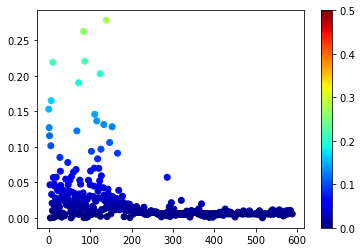

,Unnamed: 0,release_year,production_year,ratings,text_embeddings4,text_embeddings7,img_embeddings4,studio10,genres0,genres3,genres2,studio8,studio69,studio14,genres21,genres5,genres14
2671,1.314814,-0.233863,0.053130,0.211300,0.531508,-0.140380,0.013043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2077,0.484947,0.241611,0.299198,0.112140,0.930807,-0.696312,-0.331907,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
213,0.847597,-0.114994,0.176164,0.012981,1.675417,1.168687,-1.856724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.349603,-0.114994,-0.069904,0.112140,-0.606377,-0.418204,0.996173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2240,-1.621237,-2.254627,-2.038447,1.302058,-1.524428,1.260962,1.195836,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.026259,0.479348,0.791333,0.310460,-0.353392,-0.580568,-0.424767,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
702,1.576974,0.122743,0.422232,-1.573576,0.464304,-0.038561,-0.372975,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
754,0.883194,-0.233863,-0.069904,-1.474416,-1.473896,0.643617,1.004026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2185,1.189110,0.479348,0.791333,0.508780,-0.113695,-1.588197,-0.174665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:

        
"""#sns.heatmap(abs(corr))

#print(X1['ratings'].to_frame())
corr = X1['ratings'].to_frame().corrwith(Y1)
sorted_arg = np.flip(np.array(np.argsort(corr)))
# print(sorted_arg)
print(corr)
# print(Y1)"""

corrs = []
for feature in X_train.keys():
    corrs.append(np.corrcoef(X_train[feature].to_numpy(), Y_train.to_numpy().T)[0,1])
corrs = np.abs(np.array(corrs))
cm = plt.cm.get_cmap('jet')
plt.scatter(np.arange(len(X_train.keys())), corrs, cmap=cm,vmin=0, vmax=0.5, c = corrs)
plt.colorbar()
plt.show()

threshold = 0.1
#index_threshold = np.
idx = np.argwhere(corrs >= threshold).flatten()
X_train_ = X_train.iloc[:,idx]
X_test_ = X_test.iloc[:,idx]
X_train_

In [10]:
# Compute the Root Mean Square Error
def compute_rmse(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)


def run_kfold(kf, model, X_train_, Y_train_):

    X_train = np.vstack(X_train_.to_numpy())
    Y_train = np.vstack(Y_train_.to_numpy())
    Y_train *= 1e-6
    
#     scores = cross_val_score(model, X_train, Y_train, cv=5)
#     print(np.mean(scores), np.std(scores))
    RMSEs = []

    for train_index, test_index in kf.split(X_train):
        #print(train_index, test_index)
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        Y_train_fold, Y_test_fold = Y_train[train_index], Y_train[test_index]
    
        reg = model.fit(X_train_fold, Y_train_fold)
        pred = reg.predict(X_test_fold)
        
        RMSEs.append(compute_rmse(pred, Y_test_fold))
        

    return RMSEs



[1126040509443.2104, 6738435824545.229, 58.57051211290189, 67.03663979719558, 1692736182464.1453]
70.5951780070429


In [37]:
linear_regression = LinearRegression()


kf = KFold(n_splits=5, shuffle=True)
RMSEs_lin_reg = run_kfold(kf, linear_regression, X_train_, Y_train)
print(RMSEs_lin_reg)

reg = linear_regression.fit(np.vstack(X_train_.to_numpy()), np.vstack(Y_train.to_numpy())*1e-6)
pred = reg.predict(np.vstack(X_test_.to_numpy()))
print(compute_rmse(pred, Y_test*1e-6))

[57.62847452181258, 62.19872564537808, 37.733100901187505, 58.425761300394534, 50.49632875664808]
66.71598001925804


In [11]:
[68228807.51128545, 55342750.67590174, 47436705.48346283, 2.1458863134278025e+19, 49085211.264387496]
[51302320.23965559, 53204665.23217364, 64098028.60877778, 58817847.87895411, 47360406.39831142]
[50046155.695148654, 70283591.72564118, 54218039.200285316, 45833487.749843605, 48875484.988621674]
[56902495.82913592, 52930816.729666464, 58549961.640024364, 2.1887953866490302e+19, 54935597.64894027]
[66306353.30348607, 53582487.295000955, 66244246.91004766, 48682519.64086235, 57669393.144412786]

[66306353.30348607,
 53582487.295000955,
 66244246.91004766,
 48682519.64086235,
 57669393.144412786]